### 1. Import library

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torch.utils.data import Dataset,DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data.sampler import SubsetRandomSampler

from tqdm import tqdm
import random
import os
import glob
from PIL import Image

from IPython.display import Image

### 2. check cuda available

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
device

'cuda'

### 3. Dataset

In [5]:
batch_size = 256

In [6]:
train_transform = transforms.Compose([  transforms.Resize((64,64)),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.5], [0.5])
                                     ])

train_dataset = datasets.ImageFolder("./CelebA", transform = train_transform)

In [7]:
idx = list(range(len(train_dataset)))
sampler = SubsetRandomSampler(idx[:60000])

In [8]:
train_dataset[0][0].shape

torch.Size([3, 64, 64])

### 4. DataLoader

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)

In [10]:
len(train_loader)

235

In [26]:
batch_iterator = iter(train_loader)
images = next(batch_iterator)

print(images[0].shape)

torch.Size([256, 3, 64, 64])


### 5. Model Architecture   

- Generator  
- Discriminator 

In [11]:
start_size = 512

In [27]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Linear(start_size, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.layer2 = nn.Linear(1024, 2048)
        self.bn2 = nn.BatchNorm1d(2048)
        self.layer3 = nn.Linear(2048, 4096)
        self.bn3 = nn.BatchNorm1d(4096)
        self.layer4 = nn.Linear(4096, 8192)
        self.bn4 = nn.BatchNorm1d(8192)
        self.layer5 = nn.Linear(8192, 16384)
        self.bn5 = nn.BatchNorm1d(16384)
        self.relu = nn.LeakyReLU(0.1, inplace=True)
        self.tanh = nn.Tanh()
        self.last = nn.Linear(16384, 3*64*64)
        
    def forward(self, z):
        z = self.relu(self.layer1(z))
        z = self.relu(self.bn2(self.layer2(z)))
        z = self.relu(self.bn3(self.layer3(z)))
        z = self.relu(self.bn4(self.layer4(z)))
        z = self.relu(self.bn5(self.layer5(z)))
        z = self.tanh(self.last(z))
        z = z.view(z.size(0), 3, 64, 64)
        
        return z

In [28]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(3 * 64 * 64, 1024),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(128, 32),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        output = self.model(flattened)

        return output

### 6. Loss Function & Optimizer

- Generator
- Discriminator

In [29]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

gen_optim = optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
dis_optim = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.BCELoss().to(device)

### 7. Train

In [16]:
epochs = 300

for e in range(epochs):
    for i, (imgs, l) in enumerate(train_loader):
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0)
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0)
        
        real_imgs = imgs.to(device)
        
        # train generator
        gen_optim.zero_grad()
        
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], start_size)).to(device)
        
        fake_imgs = generator(z)
        
        gen_loss = criterion(discriminator(fake_imgs), real)
        
        gen_loss.backward()
        gen_optim.step()
        
        # train discriminator
        dis_optim.zero_grad()

        real_logits = criterion(discriminator(real_imgs), real)
        fake_logits = criterion(discriminator(fake_imgs.detach()), fake)

        dis_loss = (real_logits + fake_logits) / 2

        dis_loss.backward()
        dis_optim.step()
        
        done = e * len(train_loader) + i
        if e%50 == 0:
            save_image(fake_imgs.data[:25], f"generate_celebA_img/{done}.png", nrow=5, normalize=True)
            Image(f"generate_celebA_img/{done}.png")
        
    print(f"[Epoch {e}/{epochs}] dis_loss: {dis_loss.item():.6f}, gen_loss: {gen_loss.item():.6f}")

[Epoch 0/300] dis_loss: 0.241927, gen_loss: 5.151691
[Epoch 1/300] dis_loss: 0.144373, gen_loss: 2.076663
[Epoch 2/300] dis_loss: 0.147458, gen_loss: 3.146289
[Epoch 3/300] dis_loss: 0.106111, gen_loss: 2.706043
[Epoch 4/300] dis_loss: 0.506809, gen_loss: 6.169961
[Epoch 5/300] dis_loss: 0.236804, gen_loss: 1.787061
[Epoch 6/300] dis_loss: 0.071299, gen_loss: 2.917219
[Epoch 7/300] dis_loss: 0.143894, gen_loss: 2.345522
[Epoch 8/300] dis_loss: 0.352705, gen_loss: 2.022647
[Epoch 9/300] dis_loss: 0.186529, gen_loss: 2.079930
[Epoch 10/300] dis_loss: 0.519141, gen_loss: 1.263983
[Epoch 11/300] dis_loss: 0.408792, gen_loss: 2.440641
[Epoch 12/300] dis_loss: 0.294149, gen_loss: 1.692759
[Epoch 13/300] dis_loss: 0.279259, gen_loss: 2.102747
[Epoch 14/300] dis_loss: 0.529377, gen_loss: 1.387080
[Epoch 15/300] dis_loss: 0.582846, gen_loss: 1.502446
[Epoch 16/300] dis_loss: 0.530729, gen_loss: 2.885429
[Epoch 17/300] dis_loss: 0.373770, gen_loss: 1.417610
[Epoch 18/300] dis_loss: 0.187452, gen

[Epoch 151/300] dis_loss: 0.401103, gen_loss: 1.028800
[Epoch 152/300] dis_loss: 0.525805, gen_loss: 2.051682
[Epoch 153/300] dis_loss: 0.357510, gen_loss: 1.650617
[Epoch 154/300] dis_loss: 0.391843, gen_loss: 4.636003
[Epoch 155/300] dis_loss: 0.561070, gen_loss: 1.163430
[Epoch 156/300] dis_loss: 0.348522, gen_loss: 1.550895
[Epoch 157/300] dis_loss: 0.489152, gen_loss: 2.808278
[Epoch 158/300] dis_loss: 0.394858, gen_loss: 1.127644
[Epoch 159/300] dis_loss: 0.287842, gen_loss: 1.066614
[Epoch 160/300] dis_loss: 0.503478, gen_loss: 1.239065
[Epoch 161/300] dis_loss: 0.456464, gen_loss: 1.314460
[Epoch 162/300] dis_loss: 0.492387, gen_loss: 1.159175
[Epoch 163/300] dis_loss: 0.380216, gen_loss: 1.359069
[Epoch 164/300] dis_loss: 0.527797, gen_loss: 1.008877
[Epoch 165/300] dis_loss: 0.557085, gen_loss: 1.015116
[Epoch 166/300] dis_loss: 0.634094, gen_loss: 0.805538
[Epoch 167/300] dis_loss: 0.562343, gen_loss: 0.776878
[Epoch 168/300] dis_loss: 0.484829, gen_loss: 1.187228
[Epoch 169

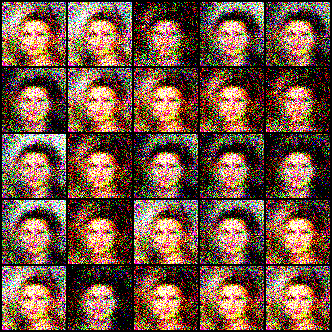

In [30]:
save_image(fake_imgs.data[:25], f"generate_celebA_img/{done}.png", nrow=5, normalize=True)
Image(f"generate_celebA_img/{done}.png")